# <center>Time Series Analysis on Pune precipitation data from 1965 to 2002.</center>

## <center>(WORKING)Algorithm: Auto Regressive Integrated Moving Average model(ARIMA)</center>

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import itertools
import warnings
warnings.filterwarnings('ignore')

### Filename

In [2]:
filename = 'pune_1965_to_2002.csv'

### Data
- Downloaded from http://www.indiawaterportal.org/met_data/
- State: Maharashtra
- District: PUNE
- Data type: Precipitation
- Data Range: Monthly mean precipitation for all the years from 1972 to 2002

In [3]:
rainfall_data_matrix = pd.read_csv(filename, delimiter='\t')
rainfall_data_matrix.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1965,0.029,0.069,0.000,21.667,17.859,102.111,606.071,402.521,69.511,5.249,16.232,22.075
1,1966,0.905,0.000,0.000,2.981,63.008,94.088,481.942,59.386,150.624,1.308,41.214,4.132
2,1967,0.248,3.390,1.320,13.482,11.116,251.314,780.006,181.069,183.757,50.404,8.393,37.685
3,1968,0.318,3.035,1.704,23.307,7.441,179.872,379.354,171.979,219.884,73.997,23.326,2.020
4,1969,0.248,2.524,0.334,4.569,6.213,393.682,678.354,397.335,205.413,24.014,24.385,1.951


<AxesSubplot:>

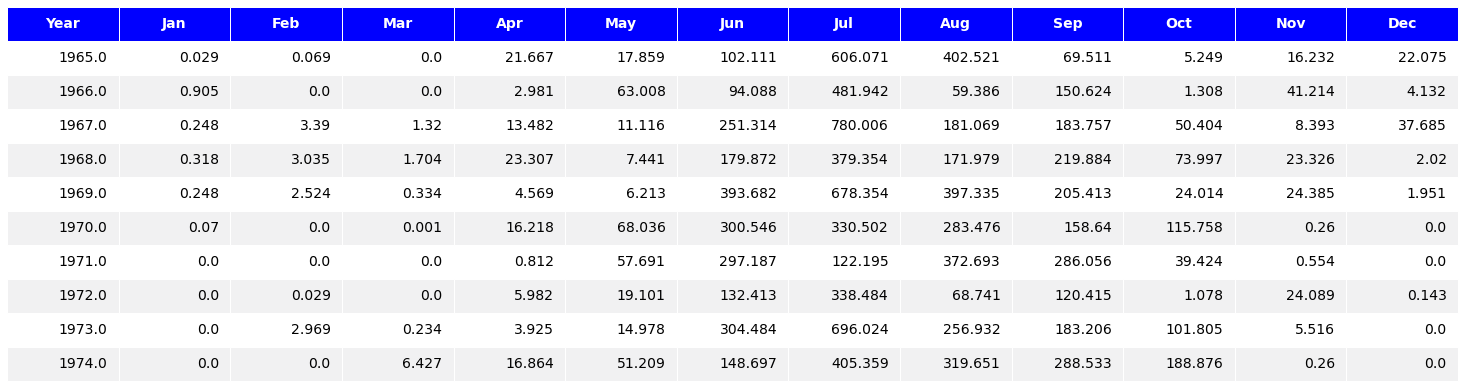

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#0000ff', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(rainfall_data_matrix.head(10).round(3), header_columns=0, col_width=2.0)

### Set 'Year' as index

In [5]:
rainfall_data_matrix.set_index('Year', inplace=True)
rainfall_data_matrix.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1965,0.029,0.069,0.000,21.667,17.859,102.111,606.071,402.521,69.511,5.249,16.232,22.075
1966,0.905,0.000,0.000,2.981,63.008,94.088,481.942,59.386,150.624,1.308,41.214,4.132
1967,0.248,3.390,1.320,13.482,11.116,251.314,780.006,181.069,183.757,50.404,8.393,37.685
1968,0.318,3.035,1.704,23.307,7.441,179.872,379.354,171.979,219.884,73.997,23.326,2.020
1969,0.248,2.524,0.334,4.569,6.213,393.682,678.354,397.335,205.413,24.014,24.385,1.951


### Transpose data for easy visualiztion

In [6]:
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
Jan,0.029,0.905,0.248,0.318,0.248,0.070,0.000,0.000,0.000,0.000,...,0.000,0.879,0.695,0.016,1.284,0.008,0.000,0.000,0.147,0.231
Feb,0.069,0.000,3.390,3.035,2.524,0.000,0.000,0.029,2.969,0.000,...,0.078,0.325,0.000,2.779,0.000,2.671,1.431,0.170,0.000,0.911
Mar,0.000,0.000,1.320,1.704,0.334,0.001,0.000,0.000,0.234,6.427,...,1.211,2.415,1.770,0.087,0.747,0.073,0.000,0.000,2.178,0.388
Apr,21.667,2.981,13.482,23.307,4.569,16.218,0.812,5.982,3.925,16.864,...,2.062,16.823,25.949,6.318,23.912,0.377,0.642,1.193,1.528,53.266
May,17.859,63.008,11.116,7.441,6.213,68.036,57.691,19.101,14.978,51.209,...,3.248,33.378,23.964,5.134,4.664,15.717,35.828,26.237,7.860,18.430
Jun,102.111,94.088,251.314,179.872,393.682,300.546,297.187,132.413,304.484,148.697,...,234.068,749.030,163.515,453.607,673.831,238.609,415.471,371.328,247.982,509.145
Jul,606.071,481.942,780.006,379.354,678.354,330.502,122.195,338.484,696.024,405.359,...,450.088,707.986,501.461,558.586,422.913,590.663,277.137,265.417,279.547,84.936
Aug,402.521,59.386,181.069,171.979,397.335,283.476,372.693,68.741,256.932,319.651,...,150.278,230.898,114.206,212.489,541.579,362.357,98.616,220.814,189.404,257.205
Sep,69.511,150.624,183.757,219.884,205.413,158.640,286.056,120.415,183.206,288.533,...,101.928,115.509,288.262,203.642,60.477,243.444,225.962,147.196,158.025,78.269
Oct,5.249,1.308,50.404,73.997,24.014,115.758,39.424,1.078,101.805,188.876,...,225.904,116.348,84.359,176.471,31.050,96.324,180.300,38.246,135.518,21.486


<AxesSubplot:>

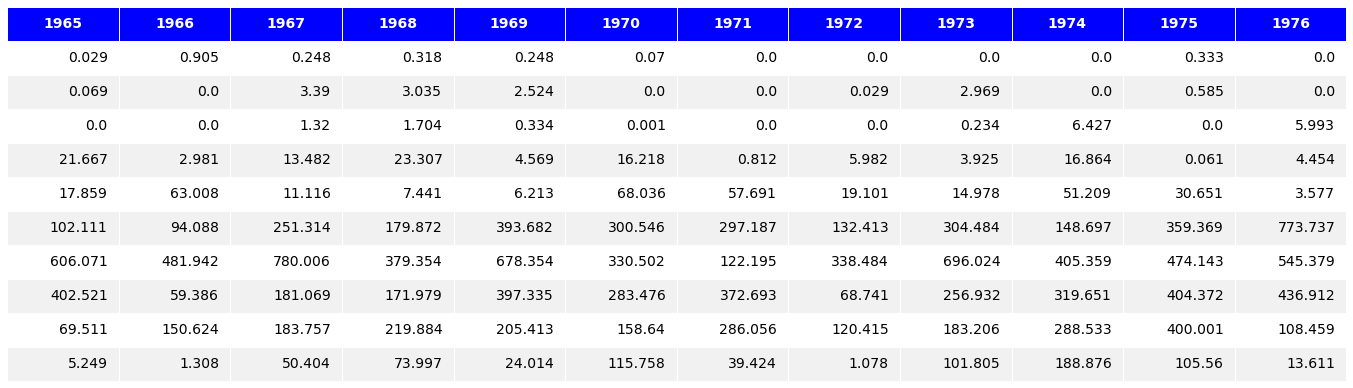

In [7]:
render_mpl_table(rainfall_data_matrix.iloc[:,0:12].head(10).round(3), header_columns=0, col_width=2.0)

### Genearete dates from 1965-01(January 1965) to 2002-12(December 2002)

In [8]:
dates = pd.date_range(start='1965-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
dates

DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=456, freq='MS')

### Visualize the whole data

Text(0.5, 1.0, 'Month vs mean precipitation across all years')

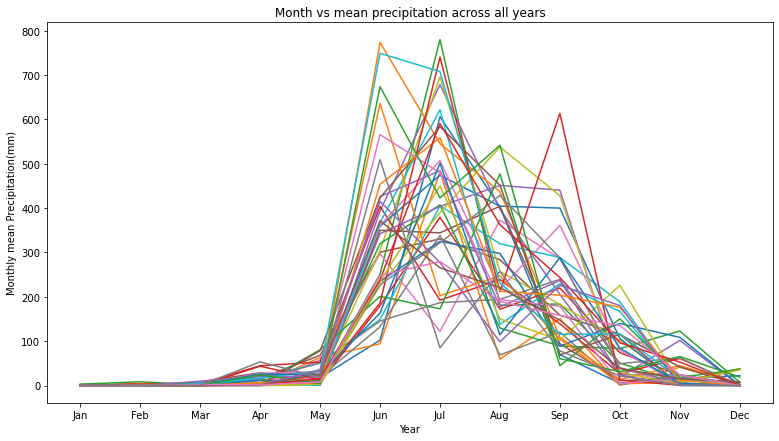

In [9]:
plt.figure(figsize=(13,7))
plt.plot(rainfall_data_matrix)
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Month vs mean precipitation across all years')

### Box plot
- Box plot helps us to understand the data better.

Text(0.5, 1.0, 'Month vs Precipitation across all years')

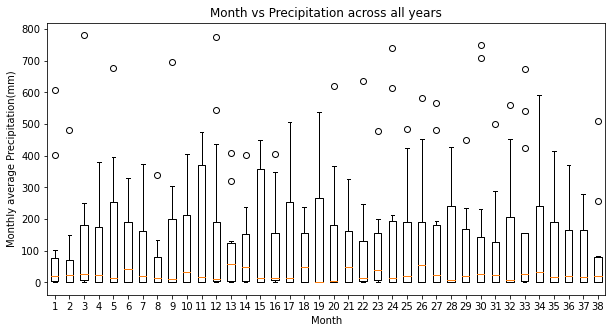

In [10]:
plt.figure(figsize=(10,5))
plt.boxplot(rainfall_data_matrix)
plt.xlabel('Month')
plt.ylabel('Monthly average Precipitation(mm)')
plt.title('Month vs Precipitation across all years')

### Box plot for average rainfall across years

In [11]:
average_rainfall_year = pd.DataFrame({'average_rainfall_year': rainfall_data_matrix.mean(axis=0)})
average_rainfall_year = average_rainfall_year.transpose()
average_rainfall_year.head()

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
average_rainfall_year,105.282833,74.965667,126.848667,90.51975,144.9185,106.125583,98.051,59.20625,130.839417,118.823,...,100.854333,165.64075,100.755667,135.94425,153.736667,133.603583,102.973583,91.171833,87.152083,85.40675


Text(0.5, 1.0, 'Year vs Average Precipitation')

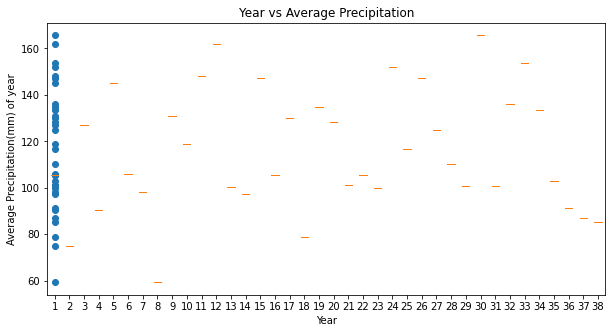

In [12]:
plt.figure(figsize=(10,5))
plt.boxplot(average_rainfall_year)
plt.scatter(x=[1] * len(average_rainfall_year.iloc[0]), y=average_rainfall_year.iloc[0])
plt.xlabel('Year')
plt.ylabel('Average Precipitation(mm) of year')
plt.title('Year vs Average Precipitation')

### Insights from the plot
- The rainfall in the months November, December, January, February, March and April is very less.
- The rainfall in the months June, July and August are high compared to rainfall in other months of the year. 
- We can observe the seasonality effect.

### Convert matrix into Series

In [13]:
# rainfall_data_matrix_np = rainfall_data_matrix.transpose().as_matrix()
rainfall_data_matrix_np = rainfall_data_matrix.transpose().to_numpy()

shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))

### Split the whole data into train(1965 - 1995) and test data(1995 - 2002)

In [14]:
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
rainfall_data.set_index(dates, inplace=True)

test_rainfall_data = rainfall_data.loc['1995': '2002']
rainfall_data = rainfall_data.loc[: '1994']
rainfall_data.head()

,Precipitation
1965-01-01,0.029
1965-02-01,0.069
1965-03-01,0.000
1965-04-01,21.667
1965-05-01,17.859


### Visualize data

Text(0.5, 1.0, 'Monthly mean Precipitation(mm) across years')

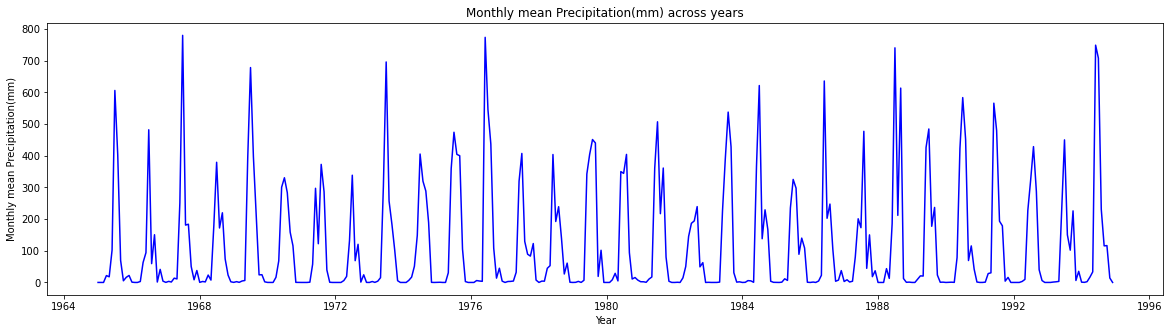

In [15]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Monthly mean Precipitation(mm) across years')

### Visualize data(zoomed version) - 5 years(1972 - 1977)

Text(0.5, 1.0, 'Monthly mean Precipitation(mm) across years')

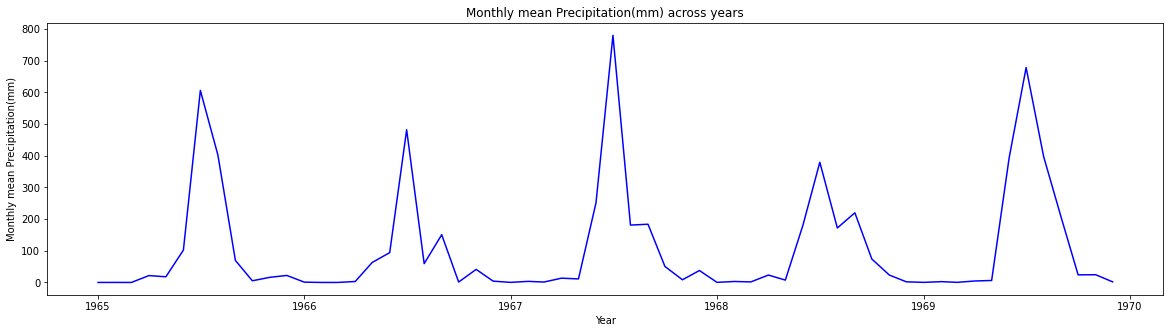

In [16]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data.iloc[:60], color='blue')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Monthly mean Precipitation(mm) across years')

### To decipher underlying patterns we must decompose the series.

In [17]:
decomposition = sm.tsa.seasonal_decompose(rainfall_data, model='additive')

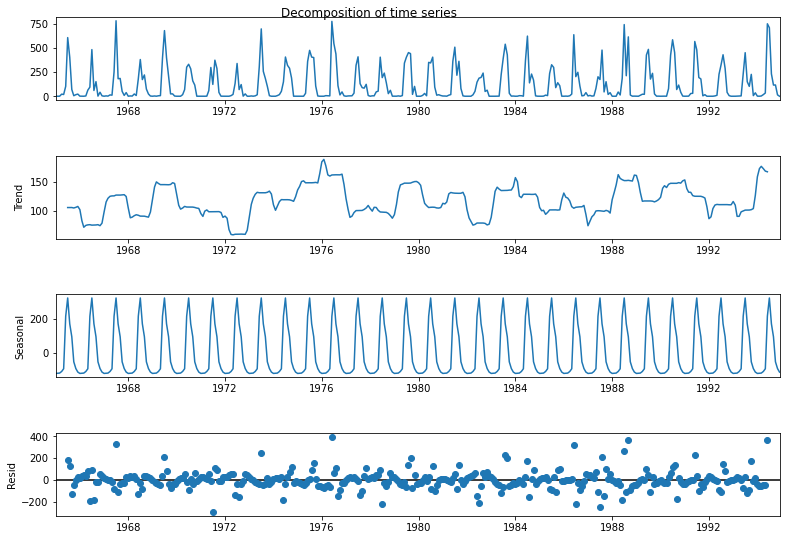

In [18]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of time series')
plt.show()

### Moving Average - Find window or seasonality time period "s"

**Moving Average** - The idea with moving average is to remove all the zigzag motion from the time series to produce a steady trend through averaging adjacent values of a time period.

Now, let’s try to remove zigzag motion from our time series using moving average. We will take moving average of different time periods i.e. 4,6,8, and 12 months as shown below. Here, moving average is shown in red and actual series in blue.

### 4- Months Moving Average

Text(0.5, 1.0, '4 Months Moving Average')

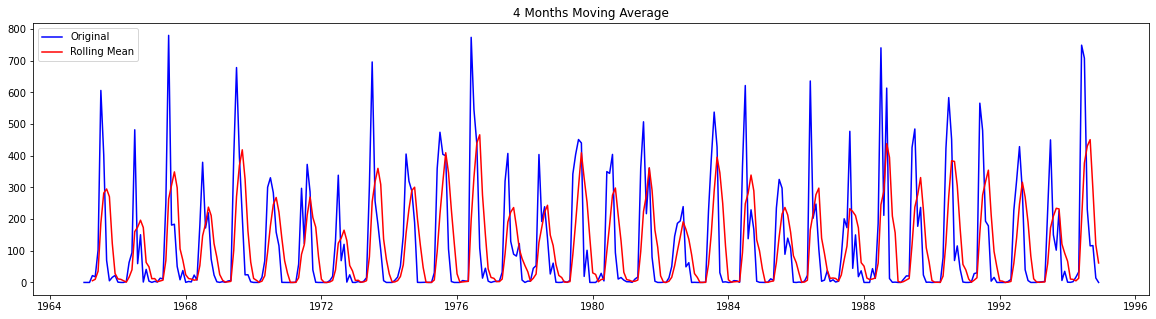

In [19]:
plt.figure(figsize=(20,5))
four_months_moving_average = rainfall_data.rolling(window=4).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(four_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('4 Months Moving Average')

### 6-Months Moving Average

Text(0.5, 1.0, '6 Months Moving Average')

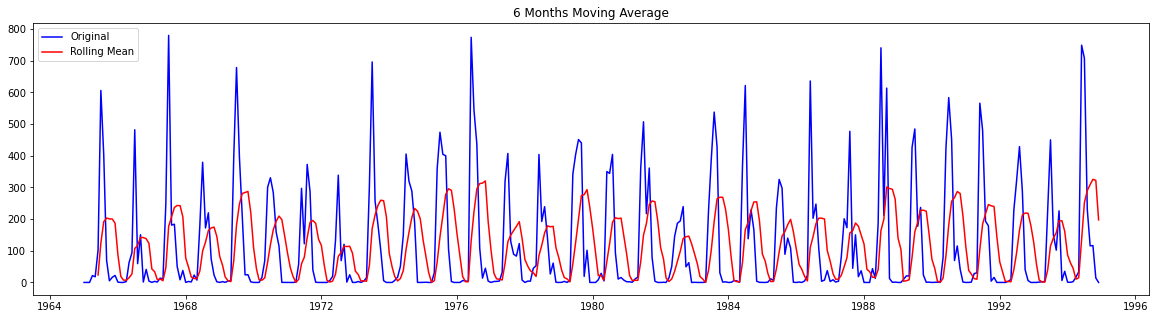

In [20]:
plt.figure(figsize=(20,5))
six_months_moving_average = rainfall_data.rolling(window=6).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(six_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('6 Months Moving Average')

### 8-Months Moving Average

Text(0.5, 1.0, '8 Months Moving Average')

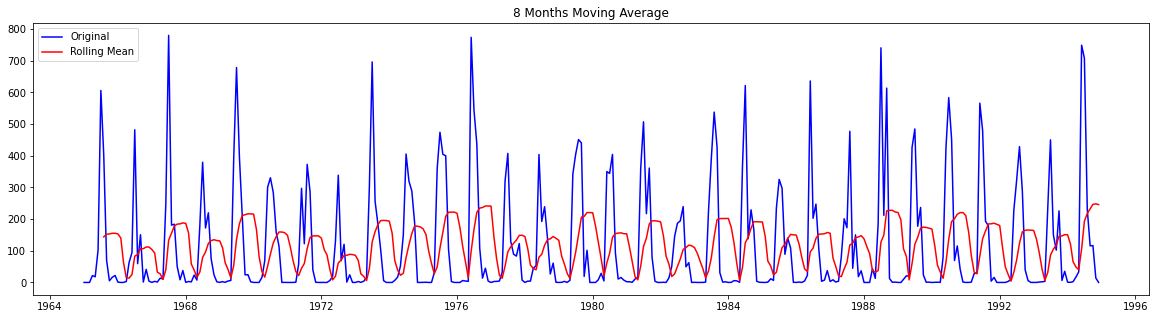

In [21]:
plt.figure(figsize=(20,5))
eight_months_moving_average = rainfall_data.rolling(window=8).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(eight_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('8 Months Moving Average')

### 12-Months Moving Average

Text(0.5, 1.0, '12 Months Moving Average')

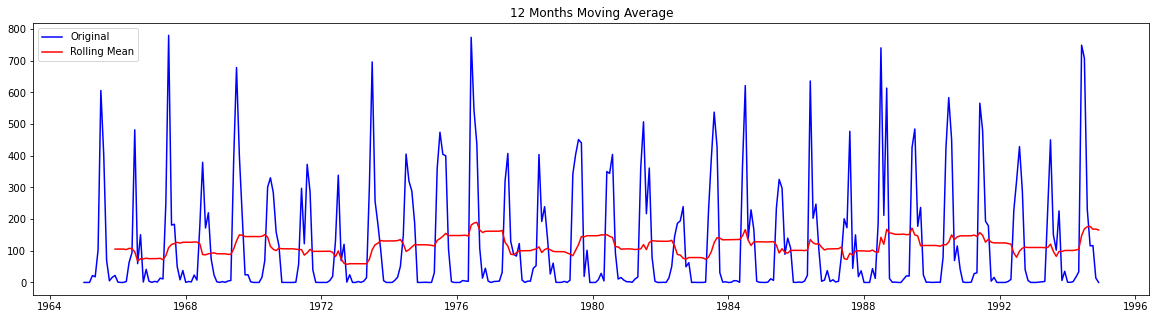

In [22]:
plt.figure(figsize=(20,5))
twelve_months_moving_average = rainfall_data.rolling(window=12).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(twelve_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('12 Months Moving Average')

### Analysis of above plots
- As we could see in the above plots, 12-month moving average could produce a wrinkle free curve when compared to other moving averages.
- Therefore, s=12.

- This is to find the period of seasonality.

### Stationarity:
- A time series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- The basic assumption before applying different models like ARIMA is that the time series should be stationary.

### How to formally check stationarity?
- There are two tests to check whether a time series is stationary or not.
    - **Rolling statistics (Visual test)** - We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant 't', we'll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
    - **Dickey Fuller test** - This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a **Test Statistic** and some **Critical Values** for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

**Let's write a function to plot and check both tests at a time.**

In [23]:
def test_stationary(timeseries, window=12):
    
    # Rolling statistics
    movingAverage = timeseries.rolling(window=window).mean()
    movingSTD = timeseries.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(20,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation\n')
    plt.show(block=False)
    
    # Dickey Fuller test
    print('Results of Dickey Fuller Test:\n')
    dftest = adfuller(timeseries['Precipitation'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

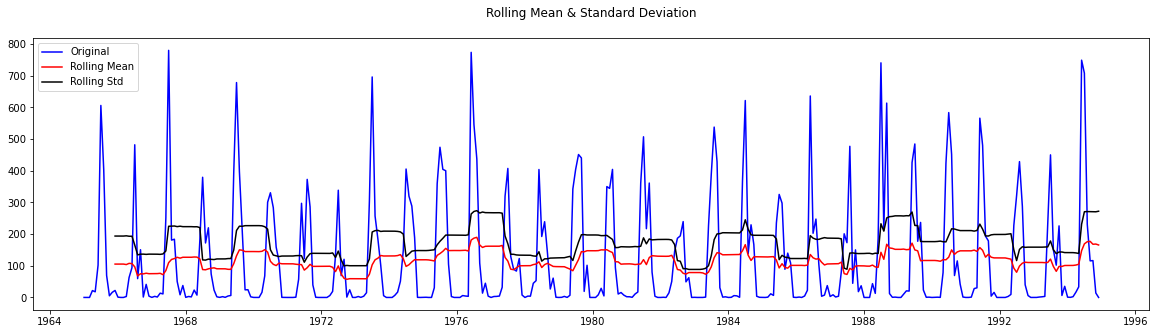

Results of Dickey Fuller Test:

Test Statistic                  -4.258992
p-value                          0.000523
No. of Lags used                11.000000
Number of observations used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


In [24]:
test_stationary(rainfall_data, window=12)

### Analysis
- As we could see, p-value is very less. Also, "Test statistic" is less compared to "Critical Value".
- Therefore, Null hypothesis is rejected, which means, Time series is stationary.

### Next steps:
- As time series is stationary, differencing is not required.
- Now, we have to find p and q values by plotting ACF and PACF plots.

### ACF and PACF plots

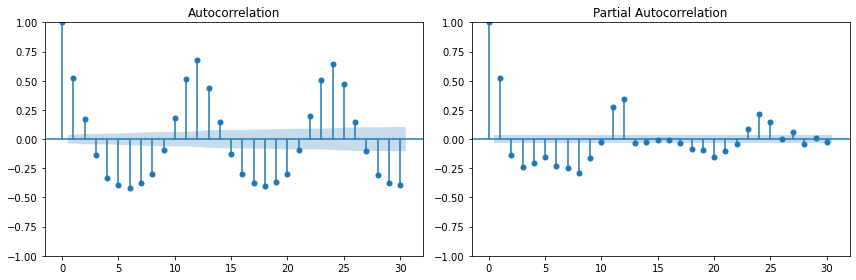

In [25]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(rainfall_data, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(rainfall_data, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

- As we could see, there is seasonality effect.

### Apply Differencing D = 1

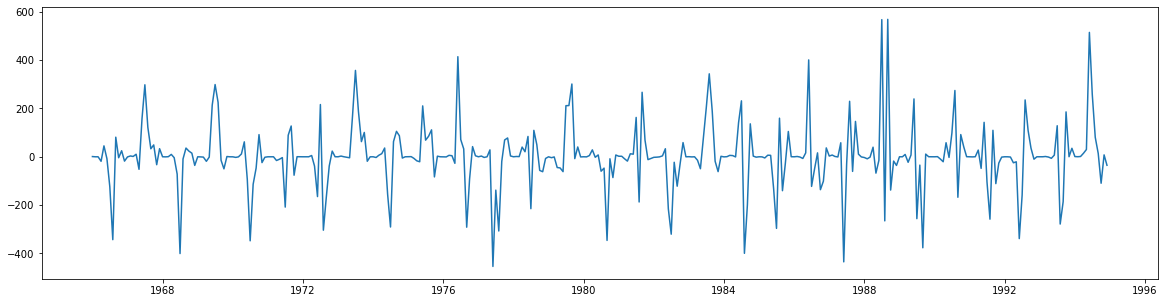

In [26]:
diff_12 = rainfall_data.diff(periods=12)
diff_12.dropna(inplace=True)

plt.figure(figsize=(20,5))
plt.plot(diff_12)

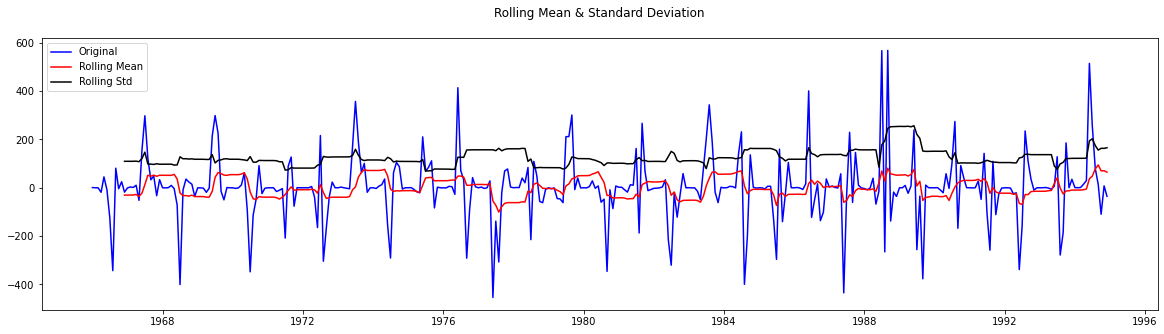

Results of Dickey Fuller Test:

Test Statistic                -8.550885e+00
p-value                        9.230261e-14
No. of Lags used               1.200000e+01
Number of observations used    3.350000e+02
Critical Value (1%)           -3.450022e+00
Critical Value (5%)           -2.870207e+00
Critical Value (10%)          -2.571387e+00
dtype: float64


In [27]:
test_stationary(diff_12)

- If there is seasonality, it will be better if we try all combinations of different parameters and choose the best set ofparameters that gives less AIC score.

### Parameters - p, d, q, P, D, Q
- Let's try all possible parameters and choose the best set of parameters that gives less AIC score.

In [28]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [29]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [30]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [31]:
AIC_scores_list = []

In [32]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:        
        try:
            
            temp_model = sm.tsa.statespace.SARIMAX(rainfall_data,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()
            l = []
            l.append(param[0])
            l.append(param[1])
            l.append(param[2])
            l.append(param_seasonal[0])
            l.append(param_seasonal[1])
            l.append(param_seasonal[2])
            l.append(param_seasonal[3])
            l.append(results.aic)
            AIC_scores_list.append(l)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76991D+00    |proj g|=  2.66454D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.665D-10   6.770D+00
  F =   6.7699060766796544     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65122D+00    |proj g|=  3.66880D-01

At iterate    5    f=  6.58411D+00    |proj g|=  1.79975D-03

At iterate   10    f=  6.56733D+00    |proj g|=  9.18595D-02

At iterate   15    f=  6.53552D+00    |proj g|=  5.10031D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     21      1     0     0   1.124D-07   6.536D+00
  F =   6.5355227190311069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83903D+00    |proj g|=  6.02980D-02

At iterate    5    f=  5.80610D+00    |proj g|=  6.67534D-04

At iterate   10    f=  5.80500D+00    |proj g|=  4.64668D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     24      1     0     0   8.400D-06   5.805D+00
  F =   5.8047742301021739     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   1.166D-05   6.266D+00
  F =   6.2664656092697770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07194D+00    |proj g|=  3.67535D-02

At iterate    5    f=  6.04634D+00    |proj g|=  1.64654D-03

At iterate   10    f=  6.02789D+00    |proj g|=  4.37202D-03

At iterate   15    f=  6.02755D+00    |proj g|=  1.55402D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  5.97122D+00    |proj g|=  8.15894D-04

At iterate   10    f=  5.97119D+00    |proj g|=  7.87616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     15      1     0     0   3.292D-06   5.971D+00
  F =   5.9711907930330961     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83327D+00    |proj g|=  1.20064D-01


 This problem is unconstrained.



At iterate    5    f=  5.81756D+00    |proj g|=  4.19939D-03

At iterate   10    f=  5.80597D+00    |proj g|=  3.77033D-02

At iterate   15    f=  5.80470D+00    |proj g|=  3.30326D-04
  ys=-5.426E-04  -gs= 3.909E-05 BFGS update SKIPPED

At iterate   20    f=  5.80413D+00    |proj g|=  1.87768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     44      1     1     0   5.871D-07   5.804D+00
  F =   5.8041249184750310     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59522D+00    |proj g|=  1.65048D-01

At iterate    5    f=  6.56732D+00    |proj g|=  2.67932D-03

At iterate   10    f=  6.56539D+00    |proj g|=  3.69556D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     17      1     0     0   1.473D-06   6.564D+00
  F =   6.5638933318592114     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89387D+00    |proj g|=  3.44944D-02

At iterate    5    f=  5.88378D+00    |proj g|=  3.40612D-03

At iterate   10    f=  5.80528D+00    |proj g|=  9.01051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   5.960D-06   5.805D+00
  F =   5.8047935354813562     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  6.36998D+00    |proj g|=  1.05114D-02

At iterate   10    f=  6.36876D+00    |proj g|=  2.49977D-02

At iterate   15    f=  6.29945D+00    |proj g|=  2.35394D-01

At iterate   20    f=  6.25435D+00    |proj g|=  1.24338D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     25      1     0     0   1.910D-08   6.254D+00
  F =   6.2543463489374593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42908D+00    |proj g|=  2.72737D-01

At iterate    5    f=  6.30025D+00    |proj g|=  3.77016D-03

At iterate   10    f=  6.26418D+00    |proj g|=  5.05025D-02

At iterate   15    f=  6.05350D+00    |proj g|=  2.20219D-02

At iterate   20    f=  6.02612D+00    |proj g|=  4.82402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     41      1     0     0   5.232D-04   6.026D+00
  F =   6.0261192823184997     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  5.98353D+00    |proj g|=  6.19874D-03

At iterate   10    f=  5.97576D+00    |proj g|=  6.26632D-02

At iterate   15    f=  5.97052D+00    |proj g|=  8.32427D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   8.324D-06   5.971D+00
  F =   5.9705163542438404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89102D+00    |proj g|=  6.87379D-02


 This problem is unconstrained.



At iterate    5    f=  5.88357D+00    |proj g|=  1.21857D-02

At iterate   10    f=  5.85231D+00    |proj g|=  1.51275D-01

At iterate   15    f=  5.80453D+00    |proj g|=  1.44057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   1.011D-06   5.805D+00
  F =   5.8045272796303964     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54388D+00    |proj g|=  1.62423D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.46857D+00    |proj g|=  3.23587D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     17      1     0     0   2.903D-06   6.468D+00
  F =   6.4678974495745578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36178D+00    |proj g|=  2.06831D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.13656D+00    |proj g|=  7.38059D-03

At iterate   10    f=  6.10946D+00    |proj g|=  1.10197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     15      1     0     0   1.048D-06   6.109D+00
  F =   6.1093981512348456     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43596D+00    |proj g|=  2.55750D-03


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   5.198D-05   6.436D+00
  F =   6.4359498382820322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51536D+00    |proj g|=  5.13497D-01

At iterate    5    f=  6.36361D+00    |proj g|=  7.94307D-02

At iterate   10    f=  6.32700D+00    |proj g|=  5.86610D-03

At iterate   15    f=  6.32043D+00    |proj g|=  1.59816D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17302D+00    |proj g|=  8.68871D-02

At iterate    5    f=  6.13471D+00    |proj g|=  1.74129D-03

At iterate   10    f=  6.11093D+00    |proj g|=  1.05706D-02

At iterate   15    f=  6.11081D+00    |proj g|=  2.98734D-03

At iterate   20    f=  6.10931D+00    |proj g|=  2.19038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     36      1     0     0   3.404D-06   6.109D+00
  F =   6.1093138630170696     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53329D+00    |proj g|=  8.95927D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.933D-05   6.533D+00
  F =   6.5332367636485742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.5

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  6.42378D+00    |proj g|=  3.29905D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   3.299D-06   6.424D+00
  F =   6.4237799916797016     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14248D+00    |proj g|=  8.18371D-02

At iterate    5    f=  6.08673D+00    |proj g|=  1.53929D-03

At iterate   10    f=  6.07313D+00    |proj g|=  5.62850D-05

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41336D+00    |proj g|=  1.65668D-01

At iterate    5    f=  6.32770D+00    |proj g|=  1.57295D-02

At iterate   10    f=  6.28111D+00    |proj g|=  2.50391D-03

At iterate   15    f=  6.22684D+00    |proj g|=  1.07460D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   8.763D-06   6.227D+00
  F =   6.2268421325651033     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate   10    f=  6.23036D+00    |proj g|=  3.81558D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     29      1     0     0   2.084D-02   6.137D+00
  F =   6.1366647711105653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.06048D+00    |proj g|=  7.62785D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  6.01392D+00    |proj g|=  2.55971D-03

At iterate   10    f=  5.96443D+00    |proj g|=  8.77255D-04

At iterate   15    f=  5.96443D+00    |proj g|=  8.96743D-04

At iterate   20    f=  5.96438D+00    |proj g|=  3.00169D-04

At iterate   25    f=  5.96437D+00    |proj g|=  4.45966D-04

At iterate   30    f=  5.96437D+00    |proj g|=  2.95861D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     32      1     0     0   2.959D-06   5.964D+00
  F =   5.9643701595960197     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99158D+00    |proj g|=  6.22817D-02

At iterate    5    f=  5.93921D+00    |proj g|=  3.65116D-03

At iterate   10    f=  5.80221D+00    |proj g|=  2.41121D-02

At iterate   15    f=  5.80011D+00    |proj g|=  6.25061D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.627D-05   5.800D+00
  F =   5.8000977536154386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.37596D+00    |proj g|=  1.27730D-03

At iterate   10    f=  6.37557D+00    |proj g|=  1.05128D-02

At iterate   15    f=  6.36575D+00    |proj g|=  3.33070D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   3.741D-06   6.364D+00
  F =   6.3643856009209561     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07835D+00    |proj g|=  1.99172D-04

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89197D+00    |proj g|=  3.48835D-02

At iterate    5    f=  5.88162D+00    |proj g|=  3.39041D-03

At iterate   10    f=  5.80482D+00    |proj g|=  3.30834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   2.766D-06   5.805D+00
  F =   5.8047731923989314     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f=  6.25694D+00    |proj g|=  4.83650D-02

At iterate   20    f=  6.25088D+00    |proj g|=  3.39726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   9.350D-07   6.251D+00
  F =   6.2508817838129289     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27767D+00    |proj g|=  9.99539D-02


 This problem is unconstrained.



At iterate    5    f=  6.20275D+00    |proj g|=  4.07276D-03

At iterate   10    f=  6.10565D+00    |proj g|=  3.23518D-02

At iterate   15    f=  6.02592D+00    |proj g|=  7.57041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     27      1     0     0   3.250D-05   6.026D+00
  F =   6.0259216338454422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98327D+00    |proj g|=  2.82856D-02

At iterate    5    f=  5.98260D+00    |proj g|=  5.42035D-03

At iterate   10    f=  5.97615D+00    |proj g|=  6.54769D-02

At iterate   15    f=  5.97048D+00    |proj g|=  4.20686D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   4.207D-06   5.970D+00
  F =   5.9704751435233110     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  5.88135D+00    |proj g|=  3.85563D-03

At iterate   10    f=  5.82162D+00    |proj g|=  5.93431D-02

At iterate   15    f=  5.80451D+00    |proj g|=  2.35261D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   2.739D-06   5.805D+00
  F =   5.8045129337197876     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47121D+00    |proj g|=  4.30986D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.37553D+00    |proj g|=  1.32705D-03

At iterate   10    f=  6.37452D+00    |proj g|=  1.36538D-02

At iterate   15    f=  6.36330D+00    |proj g|=  1.13974D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   3.110D-05   6.363D+00
  F =   6.3628560239392487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07786D+00    |proj g|=  5.20977D-03

At iter

 This problem is unconstrained.



At iterate   10    f=  6.07782D+00    |proj g|=  8.90853D-05

At iterate   15    f=  6.07782D+00    |proj g|=  9.19405D-04

At iterate   20    f=  6.07779D+00    |proj g|=  3.88128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   2.207D-06   6.078D+00
  F =   6.0777851607116444     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89347D+00    |proj g|=  3.43859D-02

At iterate    5    f=  5.88376D+00    |proj g|=  3.40160D-03

At iterate   10    f=  5.80493D+00    |proj g|=  1.97389D-02

At iterate   15    f=  5.80467D+00    |proj g|=  4.93412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   7.213D-06   5.805D+00
  F =   5.8046577065439200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate   15    f=  6.26551D+00    |proj g|=  1.52151D-02

At iterate   20    f=  6.25948D+00    |proj g|=  8.38448D-03

At iterate   25    f=  6.25105D+00    |proj g|=  1.09343D-02

At iterate   30    f=  6.24675D+00    |proj g|=  2.92865D-03

At iterate   35    f=  6.24617D+00    |proj g|=  1.81564D-04

At iterate   40    f=  6.24613D+00    |proj g|=  9.59335D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     47      1     0     0   5.680D-06   6.246D+00
  F =   6.2461207471719140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  6.03943D+00    |proj g|=  8.64920D-03

At iterate   20    f=  6.02768D+00    |proj g|=  6.49601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     34      1     0     0   7.580D-04   6.027D+00
  F =   6.0268832481351167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98404D+00    |proj g|=  2.53576D-02


 This problem is unconstrained.



At iterate    5    f=  5.98345D+00    |proj g|=  2.31929D-03

At iterate   10    f=  5.98095D+00    |proj g|=  3.40214D-02

At iterate   15    f=  5.97073D+00    |proj g|=  2.36108D-03

At iterate   20    f=  5.96602D+00    |proj g|=  1.43229D-02

At iterate   25    f=  5.96319D+00    |proj g|=  3.38447D-04

At iterate   30    f=  5.96312D+00    |proj g|=  1.38143D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     39      1     0     0   4.489D-06   5.963D+00
  F =   5.9631127833147088     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89062D+00    |proj g|=  6.84590D-02

At iterate    5    f=  5.88320D+00    |proj g|=  3.42399D-03

At iterate   10    f=  5.80507D+00    |proj g|=  2.90780D-02

At iterate   15    f=  5.80442D+00    |proj g|=  2.28930D-04

At iterate   20    f=  5.80441D+00    |proj g|=  4.11594D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   1.189D-06   5.804D+00
  F =   5.8044079374459123     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51552D+00    |proj g|=  3.96264D-01

At iterate    5    f=  6.44421D+00    |proj g|=  1.11947D-03

At iterate   10    f=  6.44325D+00    |proj g|=  2.49135D-02

At iterate   15    f=  6.43386D+00    |proj g|=  7.26914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   3.342D-06   6.434D+00
  F =   6.4337826393851465     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22797D+00    |proj g|=  1.10334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      7      1     0     0   3.750D-05   6.228D+00
  F =   6.2279675634356257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.0

 This problem is unconstrained.



At iterate    5    f=  6.38965D+00    |proj g|=  1.81512D-03

At iterate   10    f=  6.38670D+00    |proj g|=  2.84079D-02

At iterate   15    f=  6.36055D+00    |proj g|=  1.18631D-02

At iterate   20    f=  6.35930D+00    |proj g|=  5.05693D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   5.057D-06   6.359D+00
  F =   6.3592950420692329     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  6.32380D+00    |proj g|=  3.35592D-02

At iterate   10    f=  6.29709D+00    |proj g|=  6.64932D-03

At iterate   15    f=  6.19830D+00    |proj g|=  1.25536D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f=  6.18291D+00    |proj g|=  3.30859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   3.309D-03   6.183D+00
  F =   6.1829086086216147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14415D+00    |proj g|=  1.13786D-03

At iterate    5    f=  6.14361D+00    |proj g|=  1.81720D-02

At iterate   10    f=  6.13523D+00    |proj g|=  1.42231D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   8.730D-07   6.135D+00
  F =   6.1349283965069654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  6.03952D+00    |proj g|=  2.73782D-03

At iterate   10    f=  6.03510D+00    |proj g|=  3.17089D-02

At iterate   15    f=  5.97022D+00    |proj g|=  1.06110D-02

At iterate   20    f=  5.96893D+00    |proj g|=  2.45924D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     25      1     0     0   5.524D-06   5.969D+00
  F =   5.9689272257494270     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.42190D+00    |proj g|=  9.30441D-04

At iterate   15    f=  6.41541D+00    |proj g|=  1.01199D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   1.012D-06   6.415D+00
  F =   6.4154062859235408     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48962D+00    |proj g|=  3.63608D-01

At iterate    5    f=  6.37467D+00    |proj g|=  3.85983D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  6.07010D+00    |proj g|=  2.72785D-05

At iterate   20    f=  6.07005D+00    |proj g|=  1.83851D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     29      1     0     0   1.200D-04   6.070D+00
  F =   6.0700419334589650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97530D+00    |proj g|=  6.17887D-02

At iterate    5    f=  5.94059D+00    |proj g|=  4.40732D-03

At iterate   10    f=  5.84560D+00    |proj g|=  2.33314D-02

At iterate   15    f=  5.80076D+00    |proj g|=  1.34982D-03

At iterate   20    f=  5.80044D+00    |proj g|=  3.09166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   6.873D-06   5.800D+00
  F =   5.8004438075884419     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  6.29720D+00    |proj g|=  2.08522D-02

At iterate   15    f=  6.21204D+00    |proj g|=  1.81836D-02

At iterate   20    f=  6.21106D+00    |proj g|=  5.75984D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     22      1     0     0   5.760D-07   6.211D+00
  F =   6.2110575347067547     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46351D+00    |proj g|=  3.83898D-01

At iterate    5    f=  6.28029D+00    |proj g|=  3.12086D-02

At iterate   10    f=  6.23465D+00    |proj g|=  1.30910D-02

At iterate   15    f=  6.20631D+00    |proj g|=  7.05525D-03

At iterate   20    f=  6.18744D+00    |proj g|=  3.72507D-02

At iterate   25    f=  6.18271D+00    |proj g|=  3.71915D-03

At iterate   30    f=  6.05139D+00    |proj g|=  6.90890D-02

At iterate   35    f=  6.03555D+00    |proj g|=  3.36903D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  6.01980D+00    |proj g|=  7.26131D-03

At iterate   10    f=  6.00923D+00    |proj g|=  5.27533D-03

At iterate   15    f=  5.96371D+00    |proj g|=  1.47235D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   8.506D-06   5.964D+00
  F =   5.9635624613371094     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99642D+00    |proj g|=  6.95740D-02

At iterate    5    f=  5.94218D+00    |proj g|=  1.07262D-02

At iterate   10    f=  5.92361D+00    |proj g|=  8.01792D-03

At iterate   15    f=  5.80172D+00    |proj g|=  1.54708D-02

At iterate   20    f=  5.79998D+00    |proj g|=  3.50632D-03

At iterate   25    f=  5.79991D+00    |proj g|=  2.58731D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   

In [33]:
AIC_scores = pd.DataFrame.from_records(AIC_scores_list)
AIC_scores.columns=['p', 'd', 'q', 'P', 'D', 'Q', 's', 'AIC']
AIC_scores.iloc[AIC_scores['AIC'].argmin()]

p         0.000000
d         1.000000
q         1.000000
P         0.000000
D         1.000000
Q         1.000000
s        12.000000
AIC    4182.508226
Name: 27, dtype: float64

<AxesSubplot:>

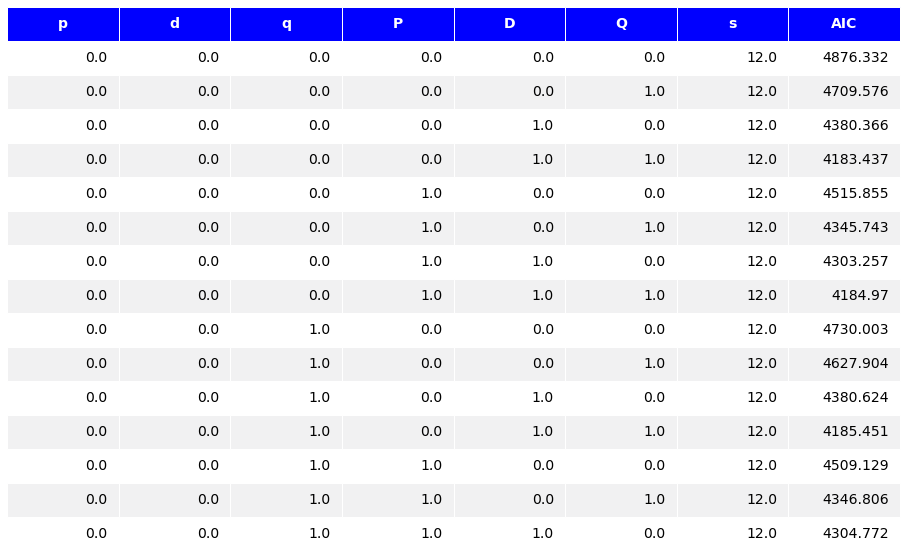

In [34]:
AIC_scores.head(15)
render_mpl_table(AIC_scores.head(15).round(3), header_columns=0, col_width=2.0)

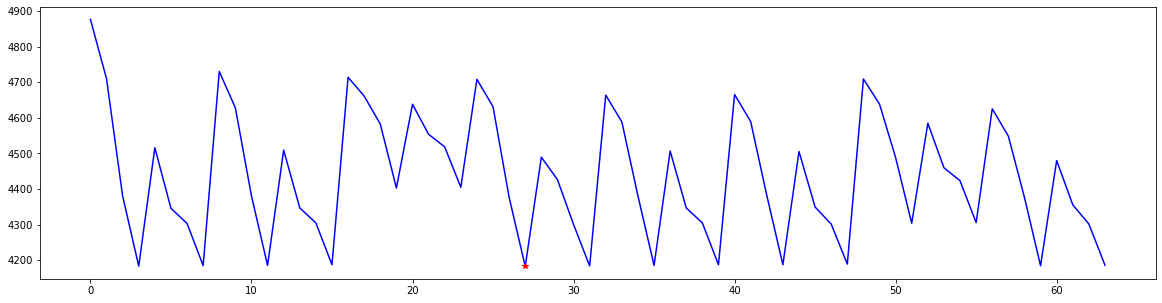

In [35]:
plt.figure(figsize=(20,5))
plt.plot(AIC_scores.AIC, color='blue')
plt.plot(27, AIC_scores.AIC[27], 'r*')

### Analysis:
- After fitting the data with different combination of models, we got the best parameters as following:
    - p = 0, d = 1, q = 1
    - P = 0, D = 1, Q = 1
    - s = 12

In [36]:
best_pdq = (0, 1, 1)
best_seasonal_pdq = (0, 1, 1, 12)

### Use the best parameters and build a model

In [37]:
best_model = sm.tsa.statespace.SARIMAX(rainfall_data,
                                      order=best_pdq,
                                      seasonal_order=best_seasonal_pdq,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97106D+00    |proj g|=  5.39088D-02


 This problem is unconstrained.



At iterate    5    f=  5.90946D+00    |proj g|=  5.04197D-03

At iterate   10    f=  5.80073D+00    |proj g|=  9.79856D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     23      1     0     0   3.731D-06   5.801D+00
  F =   5.8007058696454790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [38]:
print(best_results.summary().tables[0])

                                     SARIMAX Results                                      
Dep. Variable:                      Precipitation   No. Observations:                  360
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2088.254
Date:                            Tue, 15 Mar 2022   AIC                           4182.508
Time:                                    17:26:56   BIC                           4194.056
Sample:                                01-01-1965   HQIC                          4187.106
                                     - 12-01-1994                                         
Covariance Type:                              opg                                         


### Get predictions 

In [39]:
pd.to_datetime('1990-01-01')

Timestamp('1990-01-01 00:00:00')

In [40]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('1990-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

### Extract the predicted and true values of our time series

In [41]:
rainfall_predicted = pred_dynamic.predicted_mean
rainfall_truth = rainfall_data['1990':].Precipitation

### Compute the mean square error

In [42]:
mse = math.sqrt(((rainfall_predicted - rainfall_truth) ** 2).mean())
print('The Mean Squared Error of our predictions is {}'.format(round(mse, 4)))

The Mean Squared Error of our predictions is 97.6638


In [43]:
rainfall_data.index[-1]

Timestamp('1994-12-01 00:00:00', freq='MS')

### Visuaization of true and predicted values

In [44]:
rainfall_dummy_data = rainfall_data
rainfall_dummy_data.columns = ['Train data']

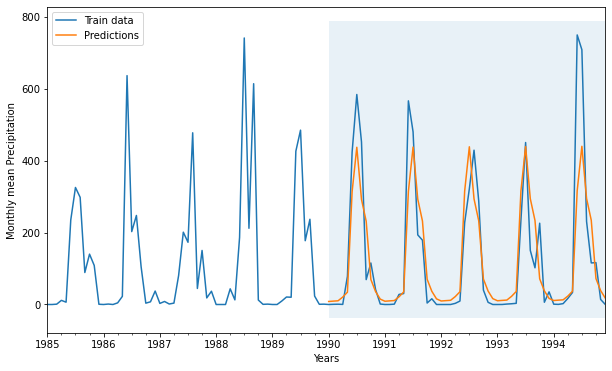

In [45]:
# Plot the actual values.
axis_plt = rainfall_dummy_data['1985':].plot(label='Train data', figsize=(10, 6))

# Plot the predicted values.
pred_dynamic.predicted_mean.plot(ax=axis_plt, label='Predictions')

# Plot confidence values and fill it with some colour.
# axis_plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.1)
axis_plt.fill_betweenx(axis_plt.get_ylim(), pd.to_datetime('1990'), rainfall_data.index[-1], alpha=0.1, zorder=-1)

# Set labels.
axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')

# Put legend on the plot at the best place it fits.
plt.legend(loc='best')

### Forecast
- Predict Precipitation for next 7 years.

In [46]:
# Get forecast 96 steps (8 years) ahead in future
n_steps = 96
pred_uc_95 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% of the forecasts
pred_ci_95 = pred_uc_95.conf_int()

In [47]:
# index = pd.date_range(rainfall_data.index[-1] + 1, periods=n_steps, freq='MS')
index = pd.date_range(rainfall_data.index[-1] + 1*rainfall_data.index[-1].freq, periods=n_steps, freq='MS')
forecast_data = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=index, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

forecast_data.head()

,forecast,lower_ci_95,upper_ci_95
1995-01-01,11.752882,-173.844091,197.349855
1995-02-01,12.528197,-173.068818,198.125213
1995-03-01,13.425251,-172.171785,199.022287
1995-04-01,23.487275,-162.109781,209.084332
1995-05-01,38.511787,-147.085290,224.108863


### Plot the forecast along with confidence band

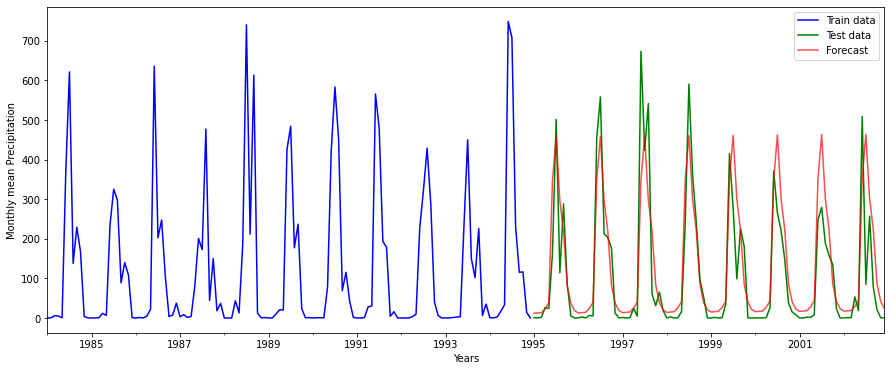

In [48]:
axis_plt = rainfall_dummy_data['1984':].plot(label='Observed', color='blue', figsize=(15, 6))

test_rainfall_data.Precipitation.plot(ax=axis_plt, color='green', label='Test data')
forecast_data['forecast'].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

# axis_plt.fill_between(forecast_data.index, forecast_data['lower_ci_95'], forecast_data['upper_ci_95'], color='k', alpha=.25)

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [49]:
dummy_test_data = test_rainfall_data
dummy_test_data.columns = ['Test data']

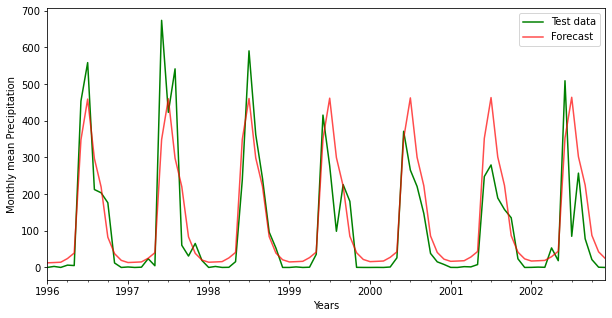

In [50]:
axis_plt = dummy_test_data['1996':].plot(label='Actual values', figsize=(10, 5), color='green')
forecast_data['forecast']['1996':].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

### Mean square error of the forecasts

In [51]:
y_true = test_rainfall_data['1995-01-01':]['Test data']
y_forecast = forecast_data['forecast']

In [52]:
mse = math.sqrt(((y_true - y_forecast) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 89.2523


### MAPE

In [53]:
mape = np.mean(np.abs((y_true - y_forecast) / (y_true))) * 100
print('The MAPE of our forecasts is {}'.format(round(mape, 4)))

The MAPE of our forecasts is inf


In [54]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [55]:
mape_vectorized_v2(y_true, y_forecast)

157.9969626218405

In [56]:
RMSE_data = [['Train RMSE', 97.66, 74.58],
            ['Test RMSE', 89.25, 91.69]]

In [57]:
RMSE_data_df = pd.DataFrame.from_records(RMSE_data)
RMSE_data_df.columns = ['Type of Data', 'RMSE of ARIMA', 'RMSE of LSTM']
RMSE_data_df

,Type of Data,RMSE of ARIMA,RMSE of LSTM
0,Train RMSE,97.66,74.58
1,Test RMSE,89.25,91.69


Text(0.5, 1.0, 'ARIMA - Train and Test RMSE')

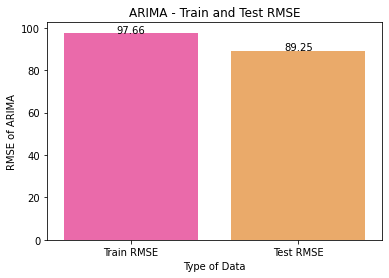

In [58]:
g = sns.barplot(x='Type of Data', y='RMSE of ARIMA', data=RMSE_data_df, palette='spring')
for index, row in RMSE_data_df.iterrows():
    g.text(row.name, row['RMSE of ARIMA'], round(row['RMSE of ARIMA'],2), color='black', ha="center")
plt.title('ARIMA - Train and Test RMSE')

Text(0.5, 1.0, 'LSTM - Train and Test RMSE')

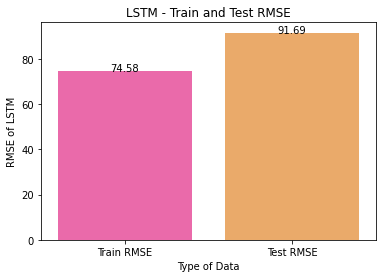

In [59]:
g = sns.barplot(x='Type of Data', y='RMSE of LSTM', data=RMSE_data_df, palette='spring')
for index, row in RMSE_data_df.iterrows():
    g.text(row.name, row['RMSE of LSTM'], round(row['RMSE of LSTM'],2), color='black', ha="center")
plt.title('LSTM - Train and Test RMSE')

Text(0.5, 1.0, 'Comparison of train and test RMSE of two algorithms')

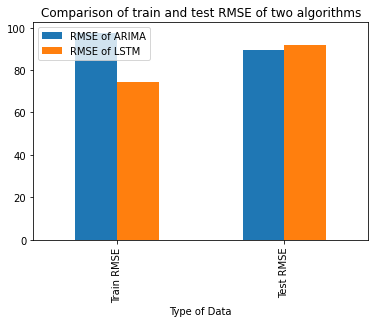

In [60]:
RMSE_data_df.plot(x="Type of Data", y=["RMSE of ARIMA", "RMSE of LSTM"], kind="bar")
plt.title('Comparison of train and test RMSE of two algorithms')

In [61]:
# Throws an error, unsure why
sns.barplot(x='Type of Data', y=['RMSE of ARIMA', 'RMSE of LSTM'], hue='Type of Data', data=RMSE_data_df, palette='spring')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().